<a href= "https://www.kaggle.com/mnassrib/telecom-churn-datasets">Orange Telecom Churn Dataset (Link to dataset)</a>

<h4>Objective</h4>
To predict if a customer will churn from Orange Telecom Company.

<h5>Evaluation Metric</h5>
F1 Score

<b>Variable Definitions</b><br>
<ul>
    <li>State: State customer is located</li>
    <li>Account length: Customer account length in days</li>
    <li>Area code: Area code of customer's location</li>
    <li>Phone number: Customer Phonenumber</li>
    <li>International plan: Does customer have International plan (Yes or No)</li>
    <li>Voicemail plan: Customer has voice mail plan (Yes or No)</li>
    <li>Number vmail messages: Customer number of voice mail messages</li>
    <li>Total day minutes: Total Call time in the daytime</li>
    <li>Total day calls: Total calls in daytime</li>
    <li>Total day charge: Total charges for calls in daytime</li>
    <li>Total eve minutes: Total Call time in the evening </li>
    <li>Total eve calls: Total calls in the evening</li>
    <li>Total eve charge: Total charges for calls in the evening</li>
    <li>Total night minutes: Total Call time at night</li>
    <li>Total night calls: Total calls at night</li>
    <li>Total night charge: Total charges for calls at night</li>
    <li>Total intl minutes: Total intl call time</li>
    <li>Total intl calls: Total Intl calls</li>
    <li>Total intl charge: Total Intl call charges</li>
    <li>Customer service calls: Customer customer service calls</li>
    <li>Churn: Target- Whether customer churned or not(True or False)</li>
</ul>

In [1]:
path = "C:/Machine_learning_datafiles/kaggle"

In [2]:
import os, gc, warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy.stats as scipy_stats

In [4]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer

In [5]:
from sklearn.model_selection import GridSearchCV

In [6]:
seed = 42
random.seed(seed)
np.random.seed(seed)

In [7]:
plt.style.use('bmh')
%matplotlib inline
pd.set_option('display.max_columns', 70)

In [8]:
data= pd.read_csv(path+'./Orange_Telcom_churn_cleaned.csv')

In [9]:
data.head()

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,TotalCalls,TotalCharges,Total_call_mins,Night_mins_per_call,Day_mins_per_call,Eve_mins_per_call,Intl_mins_per_call,Tot_mins_per_call,Night_Charges_per_mins,Day_Charges_per_mins,Eve_Charges_per_mins,Intl_Charges_per_mins,Tot_charges_per_mins
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False,300,72.86,707.2,2.689011,2.410000,1.993939,3.333333,2.357333,0.044994,0.170011,0.085005,0.270000,0.103026
1,OH,107,415,371-7191,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False,329,55.54,611.5,2.469903,1.313821,1.898058,4.566667,1.858663,0.045008,0.169988,0.085013,0.270073,0.090826
2,NJ,137,415,358-1921,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False,328,59.00,527.2,1.563462,2.135088,1.101818,2.440000,1.607317,0.045018,0.170008,0.084983,0.269672,0.111912
3,OH,84,408,375-9999,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False,248,65.02,558.2,2.212360,4.216901,0.703409,0.942857,2.250806,0.044997,0.170007,0.084976,0.269697,0.116482
4,OK,75,415,330-6626,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False,356,49.36,501.9,1.544628,1.475221,1.215574,3.366667,1.409831,0.044997,0.170006,0.085030,0.270297,0.098346


In [10]:
data.shape

(3333, 34)

In [11]:
state_churn_rate = data.groupby('state').churn.mean().sort_values(ascending=False)

In [12]:
data['intl_voicemail_plan'] = data.international_plan * data.voice_mail_plan 
#has international and voicemail plans

**Categorical Encoding**

Because of the high cardinality of the states, I'll represent each state by their churn rates.

In [13]:
def DataTypes(data, type_str='linear'):
    """Creates Data based on the type of model to use- Linear or non-linear model
    :params type_str: Model type
    :returns Data
    """
    cat_cols = ['area_code']
    data_copy = data.copy()
    
    if type_str == 'linear':
        data_copy.state = data.state.map(state_churn_rate)
        data_copy = pd.get_dummies(data_copy, columns=cat_cols, drop_first=True)
        data_copy.churn = data_copy['churn'] * 1
    elif type_str == 'non-linear':
        data_copy.state = data.state.factorize(sort=True)[0]
        data_copy = pd.get_dummies(data_copy, columns=cat_cols, drop_first=False)
        data_copy.churn = data_copy['churn'] * 1
    return data_copy

In [14]:
lin_data = DataTypes(data)
non_lin_data = DataTypes(data, 'non-linear')

**Modelling**

In [15]:
drop_cols = ['phone_number', 'total_day_minutes', 'total_eve_minutes', 
             'total_night_minutes', 'total_intl_minutes'] #columns to drop

In [16]:
lin_data.shape, non_lin_data.shape

((3333, 36), (3333, 37))

In [17]:
lin_data = lin_data.sample(frac=1, random_state=seed) #shuffling data
non_lin_data = non_lin_data.sample(frac=1, random_state=seed)

In [18]:
X_lin = lin_data.drop(drop_cols+['churn'], 1)
X = non_lin_data.drop(drop_cols+['churn'], 1)
y = lin_data.churn

In [19]:
X.shape, X_lin.shape, len(drop_cols)

((3333, 31), (3333, 30), 5)

In [20]:
xtrain_lin, xtest_lin, ytrain_lin, ytest_lin = train_test_split(X_lin, y, test_size=0.25, random_state=seed, stratify=y)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=seed, stratify=y)

In [21]:
xtrain.shape, xtest.shape, xtrain_lin.shape, xtest_lin.shape

((2499, 31), (834, 31), (2499, 30), (834, 30))

In [22]:
print(ytrain.value_counts())
print(ytest.value_counts())

0    2137
1     362
Name: churn, dtype: int64
0    713
1    121
Name: churn, dtype: int64


In [23]:
scale = ['account_length', 'number_vmail_messages', 'total_day_calls', 'total_day_charge', 'total_eve_calls', 'total_eve_charge', 
         'total_night_calls', 'total_night_charge', 'total_intl_calls', 'total_intl_charge', 'customer_service_calls', 
         'TotalCalls', 'TotalCharges', 'Total_call_mins', 'Day_mins_per_call', 'Eve_mins_per_call', 'Night_mins_per_call', 
         'Intl_mins_per_call', 'Tot_mins_per_call', 'Tot_charges_per_mins']

dont_scale = [col for col in X_lin.columns if col not in scale]

In [24]:
len(scale),len(dont_scale)

(20, 10)

In [25]:
scaler = StandardScaler()
transformer = ColumnTransformer(transformers=[
    ('scale', scaler, scale),
    ('dont_scale', 'passthrough', dont_scale)
], n_jobs=-1, remainder='passthrough')

In [26]:
def metricScores(model, x, y):
    f_score = f1_score(y, model.predict(x))
    auc_score = roc_auc_score(y, model.predict_proba(x)[:,1])
    recall = recall_score(y, model.predict(x))
    precision = precision_score(y, model.predict(x))
    return f_score, auc_score, recall, precision

def printReport(model, x, y):
    print(classification_report(y, model.predict(x),target_names=['Churn_No', 'Churn_Yes']))

def plotFigure(model, x, y, title):
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    plot_confusion_matrix(model, x, y, display_labels=['Churn_No', 'Churn_Yes'], ax=ax[0])
    plot_roc_curve(model, x, y, ax=ax[1],name=title)
    ax[0].grid(False)
    plt.tight_layout(pad=1.)

In [27]:
def featureImportance(model, x, y):
    if hasattr(model, 'named_steps'):
        if 'logreg' in model.named_steps.keys():
            imp = pd.Series(model.named_steps['logreg'].coef_.ravel(), index=x.columns).sort_values()
            imp.plot.barh(title=model.named_steps['logreg'].__class__.__name__)
    else:
        imp= pd.Series(model.feature_importances_, index=x.columns).sort_values()
        imp.plot.barh(title=model.__class__.__name__)

In [28]:
def crossValScores(model, xtr, ytr, cv=5):
    cvs= cross_val_score(model, xtr, ytr, cv=cv, scoring='f1', n_jobs=-1)
    print('Mean F1 Score: {:.3f} +- {:.3f}'.format(cvs.mean(), cvs.std()))

In [29]:
logreg = LogisticRegression(max_iter=500, random_state=seed, class_weight='balanced', solver='liblinear')
rf = RandomForestClassifier(n_estimators=200, min_samples_leaf=3, min_samples_split=3, random_state=seed, 
                            criterion='entropy', class_weight='balanced')
gbm = GradientBoostingClassifier(n_estimators=200, random_state=seed, max_features=0.3)

In [30]:
logreg_pl = Pipeline([('transformer', transformer), ('logreg', logreg)])

**Cross validation**<br>
Because the dataset is small I'll be using the sklearn's cross val score which splits a dataset into training and validation sets and stores the evaluation scores at each crossvalidation fold

In [31]:
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

In [32]:
crossValScores(logreg_pl, xtrain_lin, ytrain_lin, skfold)

Mean F1 Score: 0.524 +- 0.052


In [33]:
crossValScores(rf, xtrain, ytrain, skfold)

Mean F1 Score: 0.834 +- 0.049


In [34]:
crossValScores(gbm, xtrain, ytrain, skfold)

Mean F1 Score: 0.879 +- 0.047


<hr>

**HyperParameter Tuning**

In [35]:
def GridScores(model, xtr, ytr, params, cv=5, scoring='f1'):
    gcv = GridSearchCV(model, params, scoring=scoring, cv=cv, n_jobs=-1)
    gcv.fit(xtr, ytr)
    return gcv

In [36]:
# logreg_params = {
#     'logreg__C' : [2.5],
#     ¬'logreg__penalty': ['l2'],
#     'logreg__solver' : ['liblinear', 'lbfgs']
# }

In [37]:
# params = {
#     'min_samples_leaf' : [1],
#     'min_samples_split' : [2],
#     'max_features' : [0.3],
#     'n_estimators' : [200],
#     'max_depth' : [7],
#     'learning_rate' : [0.1]
# }

In [38]:
# gcv = GridScores(logreg_pl, xtrain_lin, ytrain_lin, logreg_params, cv=10)

In [39]:
# gcv.best_score_, gcv.best_params_

In [40]:
# gcv.cv_results_['mean_test_score']

**Optimal Parameters**
<pre>
1. logreg: 0.5307347429809155,
 {'logreg__C': 2.5, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}

2. RF: 0.8900476601264004,
 {'max_depth': 11,
  'max_features': 0.7,
  'min_samples_leaf': 1,
  'min_samples_split': 3,
  'n_estimators': 100}

3. GBM: 0.9030369075384364,
 {'learning_rate': 0.1,
  'max_depth': 7,
  'max_features': 0.3,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 200}
</pre>

<hr>

**Training and Prediction**

In [41]:
logreg = LogisticRegression(max_iter=500, random_state=seed, class_weight='balanced', C=2.5, penalty='l2', solver='liblinear')

rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, min_samples_split=3, random_state=seed, 
                            criterion='entropy', class_weight='balanced', max_depth=11, max_features=0.7)

gbm = GradientBoostingClassifier(n_estimators=200, random_state=seed, max_features=0.3, min_samples_leaf=1, 
                                 min_samples_split=2, max_depth=7, learning_rate=0.1)

In [42]:
logreg_pl = Pipeline([('transformer', transformer), ('logreg', logreg)])

<hr>

In [43]:
crossValScores(logreg_pl, xtrain_lin, ytrain_lin, skfold)

Mean F1 Score: 0.523 +- 0.050


In [44]:
crossValScores(rf, xtrain, ytrain, skfold)

Mean F1 Score: 0.874 +- 0.042


In [45]:
crossValScores(gbm, xtrain, ytrain, skfold)

Mean F1 Score: 0.897 +- 0.045


<hr>

In [46]:
def trainModel(model, xtr, ytr, xte, yte):
    model.fit(xtr, ytr)
    fscore,auc_score, recall, precision = metricScores(model, xte, yte)
    scores = pd.DataFrame({'F1':fscore, 'AUC' : auc_score, 'RECALL' : recall, 'PRECISION' : precision}, index=[1])
    return scores

In [47]:
trainModel(logreg_pl, xtrain_lin, ytrain_lin, xtest_lin, ytest_lin)

,F1,AUC,RECALL,PRECISION
1,0.536023,0.846093,0.768595,0.411504


In [48]:
trainModel(rf, xtrain, ytrain, xtest, ytest)

,F1,AUC,RECALL,PRECISION
1,0.892857,0.905753,0.826446,0.970874


In [49]:
trainModel(gbm, xtrain, ytrain, xtest, ytest)

,F1,AUC,RECALL,PRECISION
1,0.883929,0.912615,0.818182,0.961165


**Going by the Evaluation metric (F1), the best model is RandomForest, followed by GradientBoost**

<hr>
<b>Diagnostics</b>

In [50]:
printReport(logreg_pl, xtest_lin, ytest_lin)

              precision    recall  f1-score   support

    Churn_No       0.95      0.81      0.88       713
   Churn_Yes       0.41      0.77      0.54       121

    accuracy                           0.81       834
   macro avg       0.68      0.79      0.71       834
weighted avg       0.88      0.81      0.83       834



In [51]:
printReport(rf, xtest, ytest)

              precision    recall  f1-score   support

    Churn_No       0.97      1.00      0.98       713
   Churn_Yes       0.97      0.83      0.89       121

    accuracy                           0.97       834
   macro avg       0.97      0.91      0.94       834
weighted avg       0.97      0.97      0.97       834



In [52]:
printReport(gbm, xtest, ytest)

              precision    recall  f1-score   support

    Churn_No       0.97      0.99      0.98       713
   Churn_Yes       0.96      0.82      0.88       121

    accuracy                           0.97       834
   macro avg       0.97      0.91      0.93       834
weighted avg       0.97      0.97      0.97       834



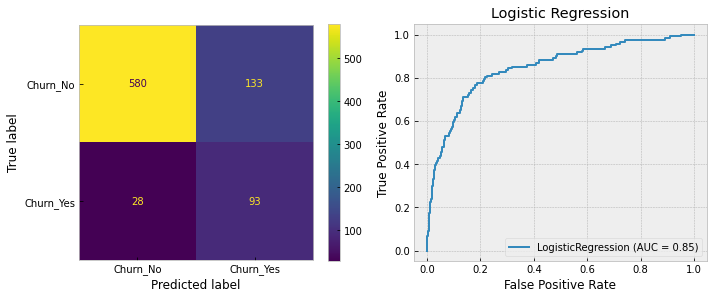

In [53]:
plotFigure(logreg_pl, xtest_lin, ytest_lin, 'LogisticRegression')
plt.title('Logistic Regression');

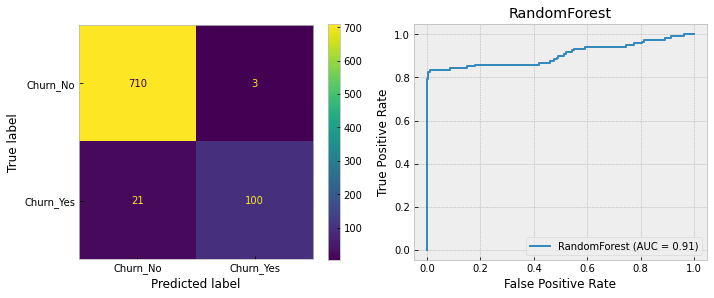

In [54]:
plotFigure(rf, xtest, ytest, 'RandomForest')
plt.title('RandomForest');

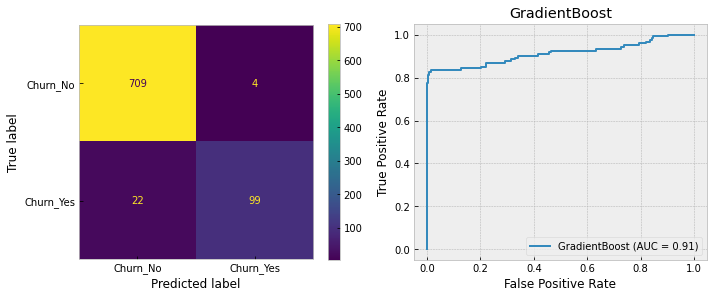

In [55]:
plotFigure(gbm, xtest, ytest, 'GradientBoost')
plt.title('GradientBoost');

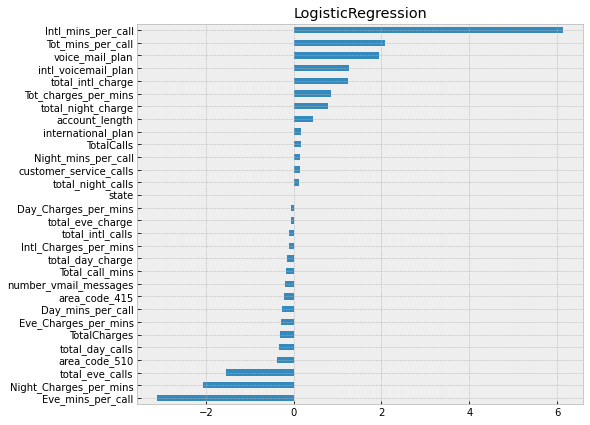

In [56]:
plt.figure(figsize=(8,7))
featureImportance(logreg_pl, xtest_lin, ytest_lin)

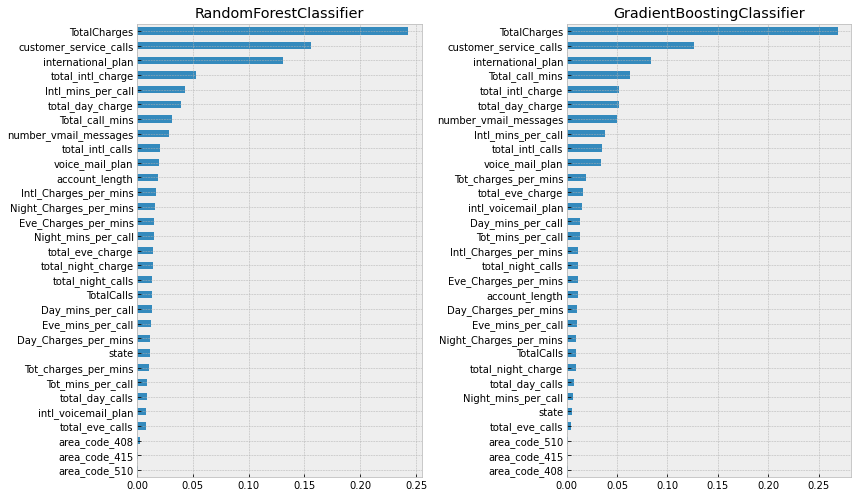

In [57]:
plt.figure(figsize=(12,7))
for i, model in enumerate([rf, gbm], start=1):
    plt.subplot(1,2,i)
    featureImportance(model, xtest, ytest)
plt.tight_layout(pad=1.)

In [58]:
gc.collect()

19686

<b>Ideas for Improvement</b>
<ul>
    <li>Feature selection may be done to select the most important features</li>
    <li>For Logistic Regression, a higher order polynomial could be used</li>
   <li>Class imbalance solution techniques: Since this dataset is class unbalanced, we could use any of the techniques metioned above to see if there's an improvement.</li>
    <li>One or more different models could be combined, where each utilises their strengths.</li>